# 3. Regression modeling
---

## Introduction

In this notebook, we will be trying to fit various regression models to predict GHI by using features that are available to us. We will be fitting our data into linear regression, random forest, and xgboost models to pick the best performance one to use in our app. 

### Contents
[Modeling](#Modeling)
- [Linear Regression](#Linear-Regression)
- [1. Ridge Regression](#1.-Ridge-Regression)
- [2. Lasso Regression](#2.-Lasso-Regression)

[Random Forest Regression](#Random-Forest-Regression)

[XGBoost Regression](#XGBoost-Regression)

[Model Interpretation and Evaluation](#Model-Interpretation-and-Evaluation)
- [Random Forest](#Random-Forest)
- [XGBoost](#XGBoost)

[Future work](#Future-work)

[Conclusion](#Conclusion)

In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
import warnings
from sklearn.inspection import permutation_importance
from scipy import stats
warnings.filterwarnings('ignore')



In [436]:
df = pd.read_csv('modified_table.csv', index_col=0)
df.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,...,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Cloud Type_tr,time,sin_time,sin_month
0,1998,1,1,0,0.0,0,0,0,0,0,...,150.94,0.157,0.6,85.25,-3.0,870.0,Super-Cooled Water,0.0,0.000000,0.258819
1,1998,1,1,0,0.5,0,0,0,0,0,...,151.93,0.157,0.6,85.27,-3.0,870.0,Overlapping,0.5,0.065403,0.258819
2,1998,1,1,1,0.0,0,0,0,0,0,...,151.73,0.157,0.7,87.96,-4.0,870.0,Cirrus,1.0,0.130526,0.258819
3,1998,1,1,1,0.5,0,0,0,0,0,...,150.36,0.157,0.7,87.98,-4.0,870.0,Cirrus,1.5,0.195090,0.258819
4,1998,1,1,2,0.0,0,0,0,0,0,...,147.99,0.157,0.8,89.34,-5.0,870.0,Cirrus,2.0,0.258819,0.258819


First, we will not use 'year' as a feature because:
- First, based on the Pearson Coeffienct test we did in EDA, the result suggests that there is no population correlation between year and GHI. 
- Second, based on the time series analysis we did for energy prediction, we did not observe a strong trend in GHI year over year. 
- Third, we want a more generalized model, fitting the model with 'year' information could increase the chance of over fitting the dataset we have and lead to a less accurate prediction.

We will also not use DNI, GHI, ClearskyDHI, ClearskyDNI, ClearskyGHI,  and Surface Albedo as we can not access these data easily, which will become a problem when we build the app.

We also have the month day and sined_month, sined_time combination. We are expecting that having the sined_month and sined_time will lead to a better performance linear regression model, however, it might not be the case for random forest and XGBoost, we will have to test it out, even for the linear regression model. Therefore we will test out which combination performs better for each model first.

We will first split the data to train and test set. To prevent data leakage, we will do all the data transformations on the train set and transform the test accordingly. Feature selection and hyperparameter tuning will be done based on a 3 fold cross-validation score on the train set.

In [499]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

We will also do the one hot encoding on the dataset for the cloud type feature. We could have embedded onehotendoing in the pipeline, however, since we will be fitting multiple models with different combinations of features, it would be less work to transform the data once

In [500]:
# fit ONE with train data and tranform test data accordingly
ohe = OneHotEncoder()
column_train = pd.DataFrame(train['Cloud Type_tr'])
column_test = pd.DataFrame(test['Cloud Type_tr'])
ohe.fit_transform(column_train)
encoded_train = ohe.transform(column_train)
encoded_test = ohe.transform(column_test)
df_cloud_train = pd.DataFrame(encoded_train.toarray(), columns=ohe.categories_[0], dtype=int)
df_cloud_test = pd.DataFrame(encoded_test.toarray(), columns=ohe.categories_[0], dtype=int)
df_cloud_test.columns

Index(['Cirrus', 'Clear', 'Fog', 'Opaque Ice', 'Overlapping', 'Overshooting',
       'Probably Clear', 'Super-Cooled Water', 'Unknown', 'Water'],
      dtype='object')

In [503]:
# concat the original data with one hot encoding data
train_OHE = pd.concat([train.reset_index(drop=True), df_cloud_train], axis=1).drop('Cloud Type_tr', axis=1)
test_OHE = pd.concat([test.reset_index(drop=True), df_cloud_test], axis=1).drop('Cloud Type_tr', axis=1)

In [513]:
train_OHE.shape, test_OHE.shape

((282072, 31), (120888, 31))

In [511]:
train_OHE.isna().sum().sum(), test_OHE.isna().sum().sum()

(0, 0)

We got the right shape, and there is no null vale in the train and test dataset.

We will be using RMSE, MAE in combination with $R^2$ to evaluate the performance of all the models.

## Modeling

### Linear Regression

First, let's check multicollinearity. Since we have 2 sets of time and month data (original and sined transform), since we will be using them one or another.

In [514]:
set_original = ['Day', 'Solar Zenith Angle',
                 'Dew Point', 'Wind Speed',
                 'Relative Humidity', 'Temperature', 'Pressure', 
                 'time', 'Month', 'Cirrus', 'Clear', 'Fog', 'Opaque Ice', 'Overlapping', 'Overshooting',
                 'Probably Clear', 'Super-Cooled Water', 'Unknown', 'Water']
set_sined = ['Day', 'Solar Zenith Angle',
             'Dew Point', 'Wind Speed',
             'Relative Humidity', 'Temperature', 'Pressure', 
             'sin_time', 'sin_month', 'Cirrus', 'Clear', 'Fog', 'Opaque Ice', 'Overlapping', 'Overshooting',
             'Probably Clear', 'Super-Cooled Water', 'Unknown', 'Water']

In [515]:
X = train_OHE[set_original]

vif_data = pd.DataFrame()
vif_data["feature"] = set_original
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

               feature          VIF
0                  Day     1.002319
1   Solar Zenith Angle     2.196510
2            Dew Point    60.413879
3           Wind Speed     1.255534
4    Relative Humidity    16.920531
5          Temperature    73.546269
6             Pressure     1.119044
7                 time     1.035349
8                Month     1.083066
9               Cirrus  3644.532613
10               Clear  3610.156150
11                 Fog    47.123497
12          Opaque Ice  1728.856351
13         Overlapping  1927.656719
14        Overshooting   141.582620
15      Probably Clear  1841.254112
16  Super-Cooled Water  2789.241512
17             Unknown    10.491481
18               Water   485.847535


In [516]:
X = train_OHE[set_sined]

vif_data = pd.DataFrame()
vif_data["feature"] = set_original
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

               feature          VIF
0                  Day     1.002656
1   Solar Zenith Angle    16.851093
2            Dew Point    60.511371
3           Wind Speed     1.246867
4    Relative Humidity    16.930079
5          Temperature    75.104855
6             Pressure     1.134749
7                 time    11.498044
8                Month     3.956165
9               Cirrus  3820.941595
10               Clear  3784.190810
11                 Fog    49.311809
12          Opaque Ice  1813.838214
13         Overlapping  2020.836399
14        Overshooting   148.596077
15      Probably Clear  1930.778161
16  Super-Cooled Water  2923.658129
17             Unknown    10.953295
18               Water   509.248484


As expected, we are seeing 'good' multicollinearity in each set, we will run a normal linear regression with PCA (to get rid of the multicollinearity) to give us a baseline idea about the $R^2$ value we can get out of a linear regression model. Since we have more than half of the features are categorical features, we will be using minmax scaler. 

**Set 1 features**

In [517]:
X_train_OHE1 = train_OHE[set_original]
X_test_OHE1 = test_OHE[set_original]
y_train = train_OHE['GHI']
y_test = test_OHE['GHI']

In [518]:
estimators = [('normalise', MinMaxScaler()),
              ('PCA', PCA()),
              ('model', LinearRegression())]

pipe = Pipeline(estimators)

In [519]:
pipe.fit(X_train_OHE1, y_train)
pipe.score(X_test_OHE1, y_test)

0.7714996106250388

We got a $R^2$ value of 0.7714 with the first set of features, now, let's take a look at the second set.

**Set 2 features**

In [520]:
X_train_OHE2 = train_OHE[set_sined]
X_test_OHE2 = test_OHE[set_sined]

In [521]:
pipe.fit(X_train_OHE2, y_train)
pipe.score(X_test_OHE2, y_test)

0.7751265158118599

The sine transform did help us to improve the $R^2$ value on the test set from 0.7715 to 0.7751.

Now we will be moving ahead to try the ridge and lasso regression model, since they will apply regularization to the variable that can help with multicollinearity, we can use the original data.

We will also create a data frame to help us to track the performance of the best model of each kind.

In [352]:
best_model_tracking = pd.DataFrame(index=['Feature', 'Model_name', 'R^2', 'MAE', 'RMSE'])
best_model_tracking

""
Feature
Model_name
R^2
MAE
RMSE


#### 1. Ridge Regression

##### 1) Feature selection

First we will use 3-fold cross validation score ($R^2$) to determine which set of features can help us to build a better performance model. This will be used for feature combination selection of all the regression models.

In [527]:
ridge_estimators = [('normalise', MinMaxScaler()),
                    ('model', Ridge())]

ridge_pipe = Pipeline(ridge_estimators)

In [528]:
cross_val_score(ridge_pipe, X_train_OHE1, y_train, cv=3).mean()

0.772214478164473

In [529]:
cross_val_score(ridge_pipe, X_train_OHE2, y_train, cv=3).mean()

0.7759126945545479

The sined transform worked better for us, we will go ahead to tune the hyperparameter for the ridge regression.

##### 2) Hyperparameter tuning

In [530]:
ridge_param = [{'normalise': [MinMaxScaler(),None],
                'model__alpha': [10**x for x in range (-5, 5)]}]
ridge_grid = GridSearchCV(ridge_pipe, ridge_param, cv=3, verbose=0, n_jobs = -1).fit(X_train_OHE2, y_train)


In [531]:
ridge_grid.best_estimator_, ridge_grid.best_score_

(Pipeline(steps=[('normalise', None), ('model', Ridge(alpha=1))]),
 0.7759317635665607)

In [532]:
ridge_pipe.fit(X_train_OHE2, y_train)
y_pred_test = ridge_pipe.predict(X_test_OHE2)
print('Model Performance')
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(ridge_pipe.score(X_test_OHE2, y_test)))

Model Performance
Root Mean Squared Error: 12008.47763307258
Mean Absolute Error: 83.64939077073998
R^s = 0.7751


In [346]:
ridge_grid.fit(X_train_OHE2, y_train)
y_pred_test = ridge_grid.predict(X_test_OHE2)
print('Model Performance')
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(fitted_ridge.score(X_test_OHE2, y_test)))

Model Performance
Root Mean Squared Error: 12008.494505684494
Mean Absolute Error: 83.61353055756706
R^s = 0.7751


We don't see an improvement on the $R^2$ value, however there is a slight decrease in MAE and RMSE, we will update our tracking table with the ridge_grid model.

In [353]:
best_model_tracking['Ridge_regression'] = ['set_sined', 'ridge_grid', 0.7751, 83.61, 12008.49]

In [541]:
filename = 'finalized_ridge_model.pkl'
joblib.dump(ridge_grid, filename)

['finalized_ridge_model.pkl']

#### 2. Lasso Regression 

##### 1)  Feature Selection

In [533]:
lasso_estimators = [('normalise', MinMaxScaler()),
                    ('model', Lasso())]

lasso_pipe = Pipeline(lasso_estimators)

In [534]:
cross_val_score(lasso_pipe, X_train_OHE1, y_train, cv=3).mean()

0.7480155032449209

In [535]:
cross_val_score(lasso_pipe, X_train_OHE2, y_train, cv=3).mean()

0.7433184639671807

With lasso regression, we actually got better performance with the original time and month data, we will proceed with hyperparameter tuning with the first set of features. 

##### 2) Hyperparameter tuning

In [536]:
lasso_param = [{'normalise': [MinMaxScaler(),None],
                'model__alpha': [10**x for x in range (-5, 5)]}]
lasso_grid = GridSearchCV(lasso_pipe, lasso_param, cv=3, verbose=0, n_jobs = -1).fit(X_train_OHE1, y_train)


In [537]:
lasso_grid.best_estimator_, lasso_grid.best_score_

(Pipeline(steps=[('normalise', None), ('model', Lasso(alpha=1e-05))]),
 0.7722346270027779)

In [538]:
lasso_pipe.fit(X_train_OHE1, y_train)
y_pred_test = lasso_pipe.predict(X_test_OHE1)
print('Model Performance')
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(lasso_pipe.score(X_test_OHE1, y_test)))

Model Performance
Root Mean Squared Error: 13472.411448450946
Mean Absolute Error: 90.02442804943621
R^s = 0.7477


In [539]:
lasso_grid.fit(X_train_OHE1, y_train)
y_pred_test = lasso_grid.predict(X_test_OHE1)
print('Model Performance')
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(lasso_grid.score(X_test_OHE1, y_test)))

Model Performance
Root Mean Squared Error: 12202.196903816199
Mean Absolute Error: 84.2657538197261
R^s = 0.7715


The R^2 value increased 0.0238 by change the alpha number to 1e-05, MAE dropped ~6, RMSE dropped ~1270.21 on the test set.

In [354]:
best_model_tracking['Lasso_regression'] = ['set_original', 'lasso_grid', 0.7715, 84.27, 12202.2]
best_model_tracking

,Ridge_regression,Lasso_regression
Feature,set_sined,set_original
Model_name,ridge_grid,lasso_grid
R^2,0.7751,0.7715
MAE,83.61,84.27
RMSE,12008.49,12202.2


In [543]:
filename = 'finalized_lasso_model.pkl'
joblib.dump(lasso_grid, filename)

['finalized_lasso_model.pkl']

So far, Ridge regression with set 1 features is winning the game.

We will go-ahead with some more complicated machine learning models.

### Random Forest Regression

After reading about how random forest model is handling categorical data, onehotencoding seems not to be a really good choice here, therefore, we will try to order encode the cloud type feature by looking at the distribution of each type of cloud over our target in the training set.

<AxesSubplot:xlabel='Cloud Type_tr', ylabel='GHI'>

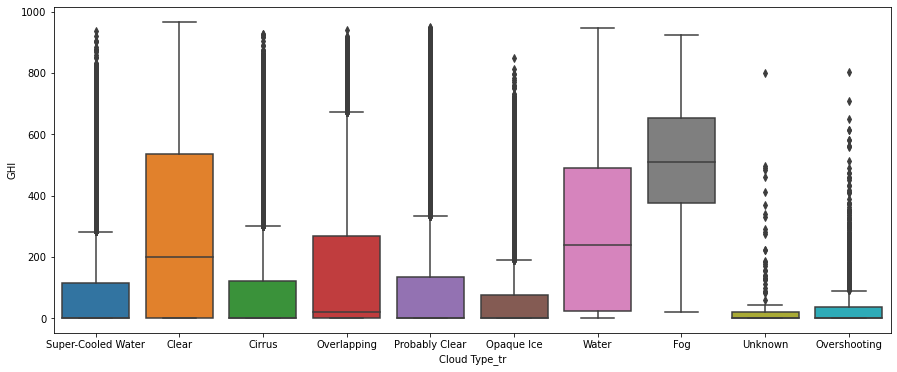

In [48]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Cloud Type_tr', y='GHI', data=train)

By looking at the box plot, we should order the cloud type by 'Unknown' - 'Overshooting' - 'Opaque Ice' - 'Super-Cooled Water' - 'Cirrus' - 'Probably Clear' - 'Overlapping' - 'Water' - 'Clear' - 'Fog'. We will transform both train and test data in the same way.                      

In [52]:
train['Cloud Type'] = train['Cloud Type_tr'].map({'Unknown':1, 
                                                  'Overshooting':2, 
                                                  'Opaque Ice':3,
                                                  'Super-Cooled Water':4,
                                                  'Cirrus':5,
                                                  'Probably Clear':6, 
                                                  'Overlapping':7, 
                                                  'Water':8, 
                                                  'Clear':9, 
                                                  'Fog':10})

In [51]:
test['Cloud Type'] = test['Cloud Type_tr'].map({'Unknown':1, 
                                                'Overshooting':2, 
                                                'Opaque Ice':3,
                                                'Super-Cooled Water':4,
                                                'Cirrus':5,
                                                'Probably Clear':6, 
                                                'Overlapping':7, 
                                                'Water':8, 
                                                'Clear':9, 
                                                'Fog':10})

#### 1. Feature selection

First, we will created a function that can fit a random forest model with given X and y and return the train score and cross validation scroe to help up select features.

In [56]:
def rf_model (X_train, y_train):
    """
    This function will fit a random forest model with given X_train and y_train
    We will use all the default hyperparameters
    This function returnes the R^value on the train set and the mean R^2 value on a 3 fold cross validation.
    """
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    cross_validation_score = cross_val_score(rf, X_train, y_train, cv=3).mean()
    train_score = rf.score(X_train, y_train)
    return train_score, cross_validation_score

We will al created a tale and a function to keep track of the performance of different combinations of features. 

In [57]:
df_feature_selection = pd.DataFrame(columns = ('features', 'R^2 train', 'R^2 cross_val'))
def feature(X, train_score, cross_val_score):
    """
    This function tracked the performace of the random forest model with diffrent combinations of features.
    Inputs of this function will be the X we used to train the model, the train score and the mean of the cross val score. 
    This function will returned an updated tracking table.
    """    

    feature_selection = pd.concat([df_feature_selection, pd.DataFrame({'features': [list(X.columns)],
                                                                        'R^2 train': [train_score],
                                                                        'R^2 cross_val': [cross_val_score]})], axis=0)
    return feature_selection

Starting with the original time and month pair.

In [58]:
X_train_1 = train[['Day', 'Solar Zenith Angle',
                 'Dew Point', 'Wind Speed',
                 'Relative Humidity', 'Temperature', 'Pressure', 
                 'time', 'Month', 'Cloud Type']]

In [59]:
y_train = train['GHI']

In [60]:
train_score, val_score = rf_model(X_train_1, y_train)
train_score, val_score

(0.9917883703821652, 0.9393437151508784)

In [61]:
df_feature_selection = feature(X_train_1, train_score, val_score)
df_feature_selection

,features,R^2 train,R^2 cross_val
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.991788,0.939344


Now we will use the sined time and month pair.

In [62]:
X_train_2 = train[['Day', 'Solar Zenith Angle',
                 'Dew Point', 'Wind Speed',
                 'Relative Humidity', 'Temperature', 'Pressure', 
                 'sin_time', 'sin_month', 'Cloud Type']]

In [63]:
train_score, val_score = rf_model(X_train_2, y_train)
df_feature_selection = feature(X_train_2, train_score, val_score)
df_feature_selection

,features,R^2 train,R^2 cross_val
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.991788,0.939344
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.991688,0.938378


The better performing model is the first one, it has the highest $R^2$ value cross-validation sets and the smallest difference between the training score and cross-validation score. The difference is marginal though.

#### 2. Tuning hyperparameters

In [70]:
X_train_forest = X_train_1
X_test_forest = test[X_train_1.columns]
y_test = test['GHI']

We will choose random search over grid search as grid search will take way to long to run. We will set the combinations of hyperparameters we want to tune first.

In [71]:
random_grid_forest = {'n_estimators': [x for x in range (100, 1000, 200)],
                      'max_features': ['auto', 'sqrt'],
                      'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, None],
                      'min_samples_split': [2, 5, 10],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],                      
                      'max_features': [x for x in range(1,X_train_forest.shape[1])]}
random_grid_forest

{'n_estimators': [100, 300, 500, 700, 900],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

Now we will perform the random search based on the huperparameters we set.

In [78]:
rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_forest, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)

rf_random.fit(X_train_forest, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900]},
                   random_state=42)

In [79]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': None,
 'bootstrap': False}

We will go ahead to save this model, as the random search did take a long time to run.

In [522]:
filename = 'rf_ramdom_search.pkl'
joblib.dump(rf_random, filename)

['rf_ramdom_search.pkl']

To campare the base model and the best model we got from the random search.

In [80]:
base_forest = RandomForestRegressor()
base_forest.fit(X_train_forest, y_train)
y_pred_test = base_forest.predict(X_test_forest)
print('Model Performance')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(base_forest.score(X_test_forest, y_test)))

Model Performance
Root Mean Squared Error: 55.29512405440596
Mean Absolute Error: 22.593345989676397
R^s = 0.9427


Since the the random search took hours to run, we will hard code the hyperparameters in the model in case we have to rerun the notebook, this way we can carry on without wait to tun the random search. 

In [81]:
best_random_forest = RandomForestRegressor(n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_features=2, max_depth=None, bootstrap=False)
best_random_forest.fit(X_train_forest, y_train)
y_pred_test = best_random_forest.predict(X_test_forest)
print('Model Performance')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(best_random_forest.score(X_test_forest, y_test)))

Model Performance
Root Mean Squared Error: 52.727821088826055
Mean Absolute Error: 22.311312915196215
R^s = 0.9479


We do see a decrease in RMSE and a 0.0052 increase in $R^2$ value. Random search helps us to narrow down the range for each hyperparameter, we could do a grid search based on the best values provided by random search to fine-tune the hyperparameter, however, based on the improvement we see random search gave us, I am not expecting a huge improvement, therefore, I decide not the spend hours to do the grid search, we will choose the result from random search as our best random forest model.

In [355]:
best_model_tracking['Random_Forest'] = ['set_original', 'best_random_forest', 0.9479, 22.31, 52.73]
best_model_tracking

,Ridge_regression,Lasso_regression,Random_Forest
Feature,set_sined,set_original,set_original
Model_name,ridge_grid,lasso_grid,best_random_forest
R^2,0.7751,0.7715,0.9479
MAE,83.61,84.27,22.31
RMSE,12008.49,12202.2,52.73


We observed an incredible increase in performance with a more complicated machine learning model. We need to note that the computational time increased substantially as well. We will go ahead to save our model.

### XGBoost Regression

Based on the reading I did, XGBoost can handle one hot encoding fairly well, therefore, we will try both one hot encoding and label encoding to choose the better performance features. We will follow the same procedure we did for choosing the best random forest model.

#### 1. Feature selection

In [388]:
def xg_model (X_train, y_train):
    """
    This function will fit a random xgboost with given X_train and y_train
    We will use all the default hyperparameters
    This function returnes the R^value on the train set and the mean R^2 value on a 3 fold cross validation.
    """
    
    xg = XGBRegressor()
    xg.fit(X_train, y_train)
    cross_validation_score = cross_val_score(xg, X_train, y_train, cv=3).mean()
    train_score = xg.score(X_train, y_train)
    return train_score, cross_validation_score

In [389]:
df_feature_selection_xg = pd.DataFrame(columns = ('features', 'R^2 train', 'R^2 cross_val'))
def feature(X, train_score, cross_val_score):
    """
    This function tracked the performace of the xgboost model with diffrent combinations of features.
    Inputs of this function will be the X we used to train the model, the train score and the mean of the cross val score. 
    This function will returned an updated tracking table.
    """    

    feature_selection = pd.concat([df_feature_selection_xg, pd.DataFrame({'features': [list(X.columns)],
                                                                          'R^2 train': [train_score],
                                                                          'R^2 cross_val': [cross_val_score]})], axis=0)
    return feature_selection

First, let's try the label encoded features.

In [390]:
train_score, val_score = xg_model(X_train_1, y_train)
train_score, val_score

(0.9482669596377435, 0.9372003435185688)

In [391]:
df_feature_selection_xg = feature(X_train_1, train_score, val_score)
df_feature_selection_xg

,features,R^2 train,R^2 cross_val
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.948267,0.9372


In [392]:
train_score, val_score = xg_model(X_train_2, y_train)
df_feature_selection_xg = feature(X_train_2, train_score, val_score)
df_feature_selection_xg

,features,R^2 train,R^2 cross_val
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.948267,0.9372
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.947796,0.936049


Like the random forest model, we got a better performance with the first combination of the features.

Now we can try with the one hot encoded features.

In [403]:
train_score, val_score = xg_model(X_train_OHE1, y_train)
df_feature_selection_xg = feature(X_train_OHE1, train_score, val_score)
df_feature_selection_xg

,features,R^2 train,R^2 cross_val
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.948267,0.9372
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.947796,0.936049
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.949278,0.937524


In [404]:
train_score, val_score = xg_model(X_train_OHE2, y_train)
df_feature_selection_xg = feature(X_train_OHE2, train_score, val_score)
df_feature_selection_xg

,features,R^2 train,R^2 cross_val
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.948267,0.9372
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.947796,0.936049
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.949278,0.937524
0,"[Day, Solar Zenith Angle, Dew Point, Wind Spee...",0.948494,0.936523


We got the best result with one hoe encoded cloud type columns, and the original date and time data, therefore, they will be used for building the model and we will go ahead with hyperparameter tuning. One thing to note, the difference is really marginal.

#### 2. Tuning hyperparameters

In [424]:
X_train_OHE1.columns

Index(['Day', 'Solar Zenith Angle', 'Dew Point', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', 'time', 'Month',
       'Cirrus', 'Clear', 'Fog', 'Opaque Ice', 'Overlapping', 'Overshooting',
       'Probably Clear', 'Super-Cooled Water', 'Unknown', 'Water'],
      dtype='object')

In [425]:
X_test_OHE1.columns

Index(['Day', 'Solar Zenith Angle', 'Dew Point', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', 'time', 'Month',
       'Cirrus', 'Clear', 'Fog', 'Opaque Ice', 'Overlapping', 'Overshooting',
       'Probably Clear', 'Super-Cooled Water', 'Unknown', 'Water'],
      dtype='object')

In [427]:
X_train_xg = X_train_OHE1
X_test_xg = X_test_OHE1

In [65]:
random_grid_xg = {'n_estimators': [x for x in range (100, 1100, 100)],
                  'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'max_depth': [x for x in range(5, 20, 2)],
                  'min_child_weight': [x for x in range(5,9)],
                  'subsample': [x/10. for x in range(5,11)],
                  'colsample_bytree': [x/10. for x in range(5,11)]}
random_grid_xg

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'max_depth': [5, 7, 9, 11, 13, 15, 17, 19],
 'min_child_weight': [5, 6, 7, 8],
 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

In [66]:
xg = XGBRegressor()
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid_xg, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)

xg_random.fit(X_train_xg, y_train)

/Users/wenjinzhou/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/wenjinzhou/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/wenjinzhou/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/wenjinzhou/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pa

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
        

In [67]:
xg_random.best_params_

{'subsample': 0.6,
 'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 17,
 'learning_rate': 0.01,
 'gamma': 0.5,
 'colsample_bytree': 0.7}

In [429]:
base_xg = XGBRegressor()
base_xg.fit(X_train_xg, y_train)
y_pred_test = base_xg.predict(X_test_xg)
print('Model Performance')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(base_xg.score(X_test_xg, y_test)))

Model Performance
Root Mean Squared Error: 56.75164697430083
Mean Absolute Error: 24.222833470865986
R^s = 0.9397


Same reason as the random forest model, we will hard code the hyperparameters since it took a long time to random search for the best combination of the hyperparameters.

In [428]:
best_random_xg = XGBRegressor(subsample=0.6, n_estimators=1000, min_child_weight=5, max_depth=17, learning_rate=0.01, gamma=0.5, colsample_bytree=0.7)
best_random_xg.fit(X_train_xg, y_train)
y_pred_test = best_random_xg.predict(X_test_xg)
print('Model Performance')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('R^s = {:0.4f}'.format(best_random_xg.score(X_test_xg, y_test)))

Model Performance
Root Mean Squared Error: 53.11178478236719
Mean Absolute Error: 22.312848475150382
R^s = 0.9472


We did see the improvement of 0.75 on the $R^2$ value and reduction on RMSE

In [430]:
best_model_tracking['XGBoost'] = ['set_original', 'best_random_xg', 0.9472, 22.31, 53.11]
best_model_tracking

,Ridge_regression,Lasso_regression,Random_Forest,XGBoost
Feature,set_sined,set_original,set_original,set_original
Model_name,ridge_grid,lasso_grid,best_random_forest,best_random_xg
R^2,0.7751,0.7715,0.9479,0.9472
MAE,83.61,84.27,22.31,22.31
RMSE,12008.49,12202.2,52.73,53.11


In [435]:
filename = 'finalized_xgboost_model.pkl'
joblib.dump(best_random_xg, filename)

['finalized_xgboost_model.pkl']

##  Model Interpretation and Evaluation

We did get the best performance from the random forest model by a small margin of 0.0007, and a lower RMSE of 0.38. However, due to the size of the file of the random forest model (16.16 GB), it is not feasible to deploy it in the app as it will crash the app, therefore, the XGBoost model will be deployed in the app. Both of the models will be evaluated, we will start with the random forest model.

### Random Forest

#### 1) Model Interpretation

First, we will try to interpret the model by looking at the importance of the features.

In [212]:
forest = pd.DataFrame(data = {'Feature': X_train_forest.columns, 
                              'Importance': best_random_forest.feature_importances_}).sort_values(by='Importance', ascending=False)
forest

,Feature,Importance
1,Solar Zenith Angle,0.384911
4,Relative Humidity,0.228239
5,Temperature,0.123973
7,time,0.105256
9,Cloud Type,0.080634
8,Month,0.023934
2,Dew Point,0.021573
3,Wind Speed,0.015894
0,Day,0.011191
6,Pressure,0.004395


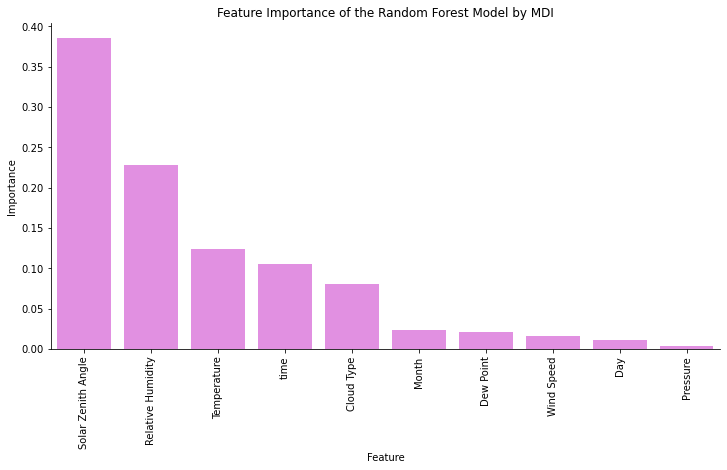

In [544]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Importance', color='Violet', data=forest).set_title('Feature Importance of the Random Forest Model by MDI')
plt.xticks(rotation=90)
sns.despine()
plt.show()

The table above shows us how important each feature is for the model, by using the mean decrease in impurity method. There is no surprise that the solar zenith angle plays the most important role to determine solar irradiance. On the other hand, pressure is the least important feature to predict solar irradiance. We will also look into the permutation feature importance.

In [493]:
rf_result = permutation_importance(best_random_forest, X_test_forest, y_test, n_repeats=100, random_state=0)

In [495]:
importances = rf_result.importances_mean

normalized_importances = importances / importances.sum()


permute_importances_df = pd.DataFrame({'Variable': X_train_forest.columns,
                                       'Normalized Importance': normalized_importances})

permute_importances_df.sort_values(by='Normalized Importance', ascending=False, inplace=True, ignore_index=True)


In [496]:
permute_importances_df

,Variable,Normalized Importance
0,Solar Zenith Angle,0.638683
1,Cloud Type,0.142618
2,time,0.071885
3,Relative Humidity,0.071846
4,Temperature,0.027211
5,Month,0.020740
6,Dew Point,0.009971
7,Wind Speed,0.007250
8,Day,0.005937
9,Pressure,0.003858


Since it took 13 hours the result for the permute importance result, I will save it so that we can pull it out in the future if we need to.

In [497]:
permute_importances_df.to_pickle('RF_permute_importance_table.pkl')

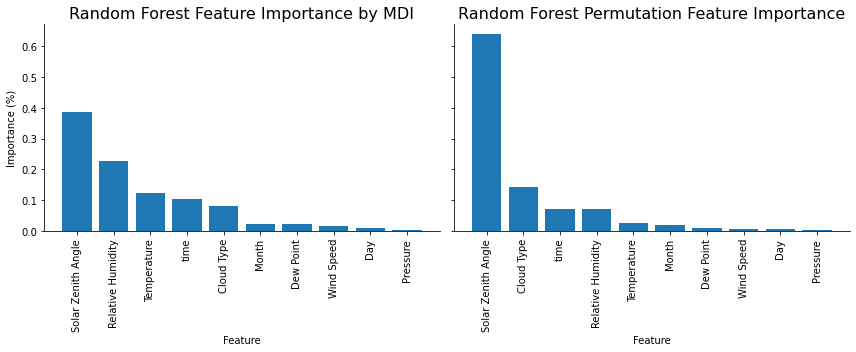

In [498]:
plt.subplots(1, 2, figsize=(12,5), sharey=True)

plt.subplot(1, 2, 1) # MDI method
plt.bar(forest['Feature'], forest['Importance'])
plt.title('Random Forest Feature Importance by MDI', fontsize=16)
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
plt.xticks(rotation = 90)
sns.despine()

plt.subplot(1, 2, 2) # Permutation Feature Importance
plt.bar(permute_importances_df['Variable'], permute_importances_df['Normalized Importance'])
plt.title('Random Forest Permutation Feature Importance', fontsize=16)
plt.xlabel('Feature')

plt.xticks(rotation = 90)
sns.despine()


plt.tight_layout()
plt.show()

By comparing them side to side. we can see for both methods, the most important feature is the solar zenith angle, and the 5 least important features are month, dew point, wind speed, day, and pressure. The order of importance of other features in each method differs. The solar zenith angle is relatively more important to predict the target by using the permutation method.

Now, let's evaluate the model.

#### 2) Model Evaluation

In [468]:
result_rf = X_test_forest.copy()
result_rf['Predictions'] = y_pred_test
result_rf['Residual'] = result_rf['Predictions'] - y_test
result_rf['Actual'] = y_test

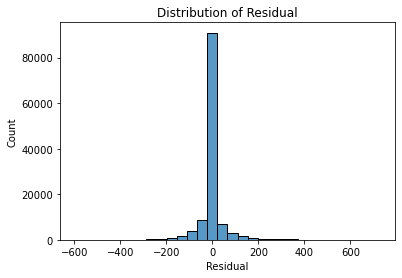

In [457]:
sns.histplot(x='Residual', data=result_rf, bins=30)
plt.title('Distribution of Residual')
plt.show()

It does look like the mean of the residual is 0, however, the variance does look really high for the shape of this distribution. We can take a look at the QQ plot too.

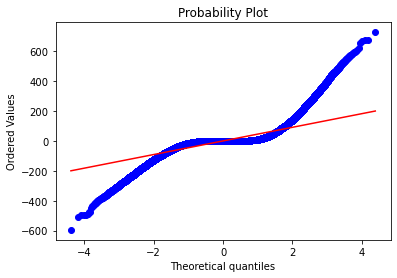

In [464]:
stats.probplot(result_rf['Residual'], dist='norm', plot=plt)
plt.show()

This shows the exact trend the distribution plot is showing us. The residuals between the predicted values and the actual values are not normally distributed.

Now let's take a look at how the residuals are scattered with every feature and the predictions.

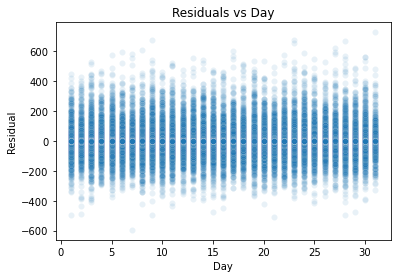

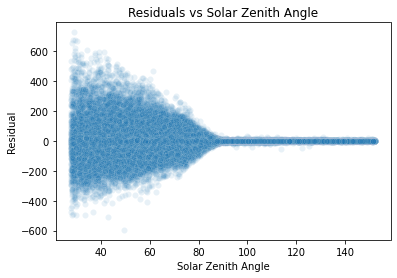

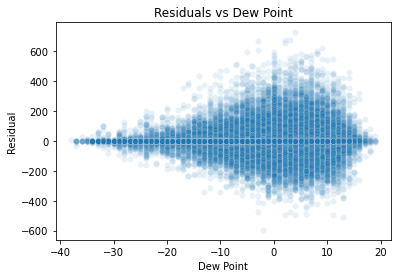

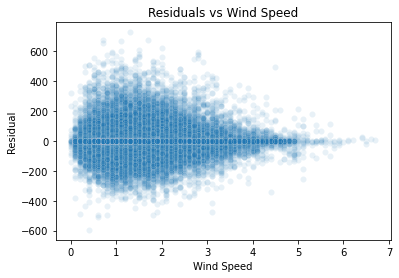

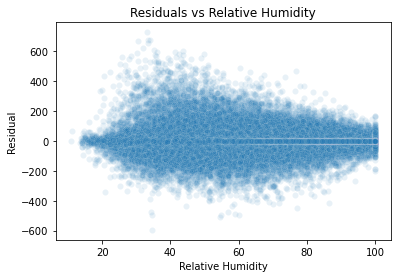

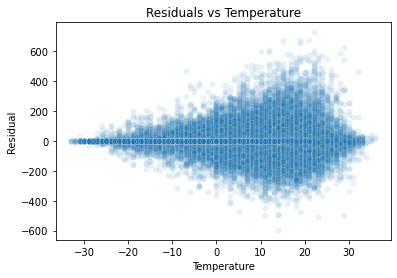

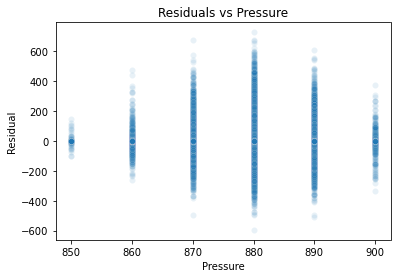

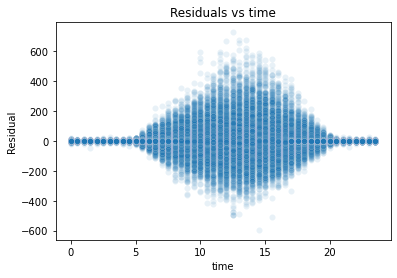

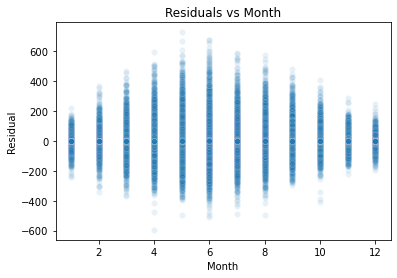

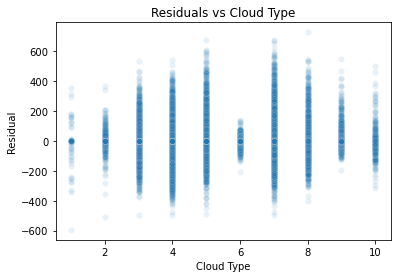

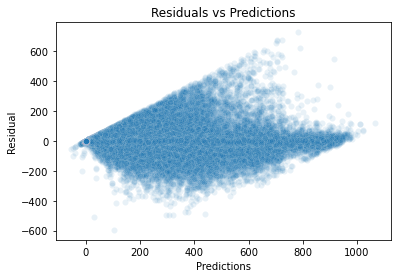

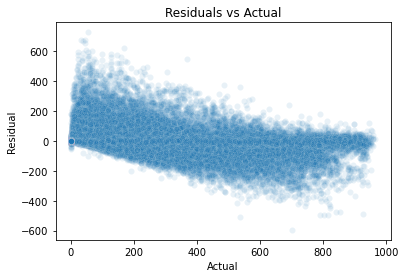

In [471]:
for col in result_rf.drop('Residual', axis=1):
    sns.scatterplot(x=col, y='Residual', data=result_rf, alpha=0.1)
    plt.title(f'Residuals vs {col}')
    plt.show()

from all the plots above, it does look like the the model predicts during winder than summer, it predicts better during the nights than days. From the last 2 plot, we can see that we got higher chance to have a lower accurate prediction while the predicted value is between 200 to 600.

### XGBoost

We will follow the same procedure of what we did with the random forest model.

#### 1) Model Interpretation

In [430]:
best_model_tracking['XGBoost'] = ['set_original', 'best_random_xg', 0.9472, 22.31, 53.11]
best_model_tracking

,Ridge_regression,Lasso_regression,Random_Forest,XGBoost
Feature,set_sined,set_original,set_original,set_original
Model_name,ridge_grid,lasso_grid,best_random_forest,best_random_xg
R^2,0.7751,0.7715,0.9479,0.9472
MAE,83.61,84.27,22.31,22.31
RMSE,12008.49,12202.2,52.73,53.11


In [431]:
xgboost = pd.DataFrame(data = {'Feature': X_train_xg.columns, 
                               'Importance': best_random_xg.feature_importances_}).sort_values(by='Importance', ascending=False)
xgboost

,Feature,Importance
10,Clear,0.258197
1,Solar Zenith Angle,0.179285
15,Probably Clear,0.088855
12,Opaque Ice,0.076505
14,Overshooting,0.068693
16,Super-Cooled Water,0.049824
4,Relative Humidity,0.045974
7,time,0.045710
5,Temperature,0.033005
17,Unknown,0.030702


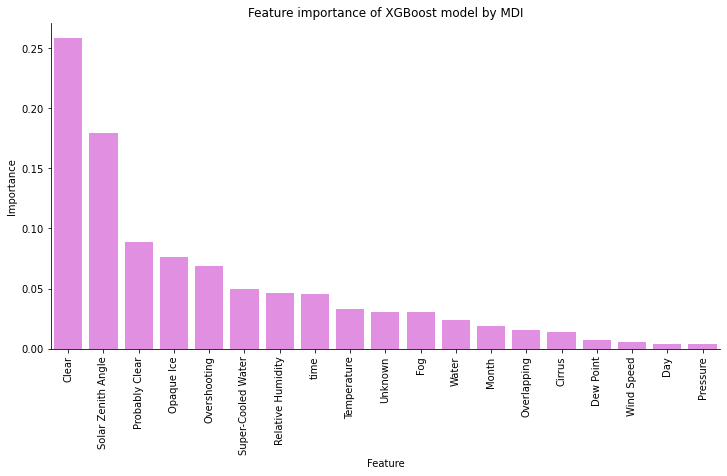

In [472]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Importance', color='violet',data=xgboost).set_title('Feature importance of XGBoost model by MDI')

plt.xticks(rotation=90)
sns.despine()
plt.show()

By using the MBI method, we see the mode import feature is the sky being clear. Now let's take a look at that the permutation method is telling us.

In [240]:
xg_result = permutation_importance(best_random_xg, X_test_xg, y_test, n_repeats=100, random_state=0)

In [247]:
importances = xg_result.importances_mean

normalized_importances = importances / importances.sum()

xg_permute_importances_df = pd.DataFrame({'Variable': X_train_xg.columns,                             
                                          'Normalized Importance': normalized_importances})

xg_permute_importances_df.sort_values(by='Normalized Importance', ascending=False, inplace=True, ignore_index=True)


In [248]:
xg_permute_importances_df

,Variable,Normalized Importance
0,Solar Zenith Angle,0.698177
1,time,0.078033
2,Clear,0.058803
3,Relative Humidity,0.050549
4,Temperature,0.019331
5,Opaque Ice,0.018489
6,Probably Clear,0.017943
7,Super-Cooled Water,0.016564
8,Month,0.016429
9,Dew Point,0.007300


In [249]:
xg_permute_importances_df.to_csv('XG_permute_importance_table.csv')
xg_permute_importances_df.to_pickle('XG_permute_importance_table.pkl')

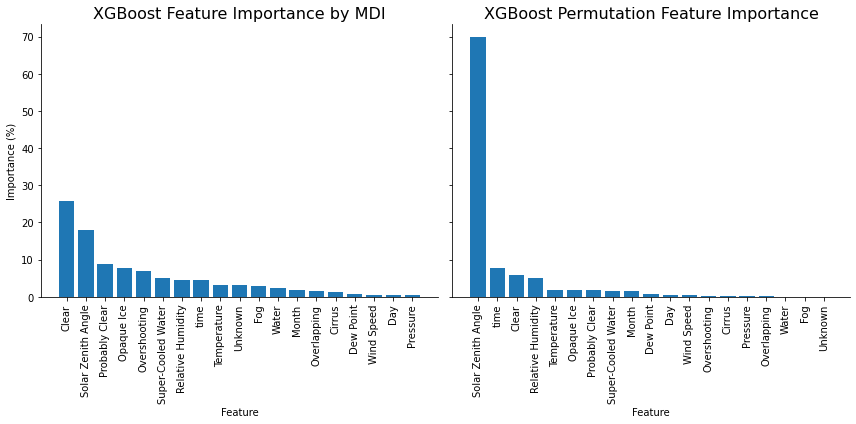

In [526]:
plt.subplots(1, 2, figsize=(12,6), sharey=True)

plt.subplot(1, 2, 1) # MDI method
plt.bar(xgboost['Feature'], xgboost['Importance']*100)
plt.title('XGBoost Feature Importance by MDI', fontsize=16)
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
plt.xticks(rotation = 90)
sns.despine()

plt.subplot(1, 2, 2) # Permutation Feature Importance
plt.bar(xg_permute_importances_df['Variable'], xg_permute_importances_df['Normalized Importance']*100)
plt.title('XGBoost Permutation Feature Importance', fontsize=16)
plt.xlabel('Feature')

plt.xticks(rotation = 90)
sns.despine()


plt.tight_layout()
plt.show()

The permutated importance showed us the most important feature is the solar zenith angle, followed by time and sky being clear. If we look at this chart with a comparison of the importance chart from the random forest model, and even the correlation coefficient chart we did in the EDA notebook. I would suggest that the solar zenith angle is the most important feature to determine the GHI value.


#### 2) Model Evaluation

In [490]:
result_xg = X_test_xg.copy()
result_xg['Predictions'] = best_random_xg.predict(X_test_xg)
result_xg['Residual'] = result_xg['Predictions'] - y_test
result_xg['Actual'] = y_test

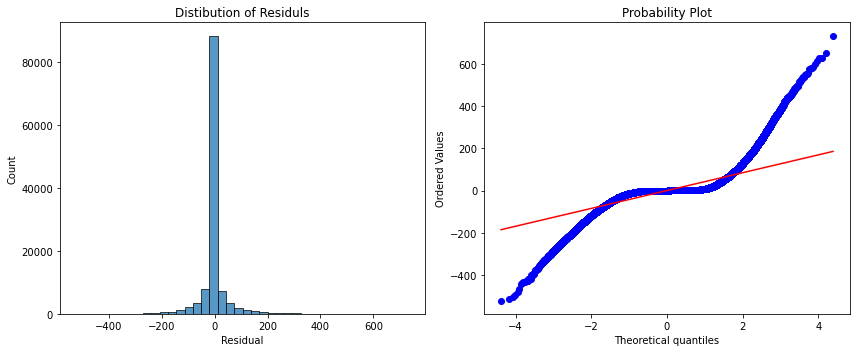

In [477]:
plt.subplots(1, 2, figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(x='Residual', data=result_xg, bins=40)
plt.title('Distibution of Residuls')
plt.subplot(1, 2, 2)
stats.probplot(result_xg['Residual'], dist='norm', plot=plt)
plt.tight_layout()
plt.show()

We do observe the same issue here with the XGBoost model, the mean seems to be around 0, however, the variance is high.

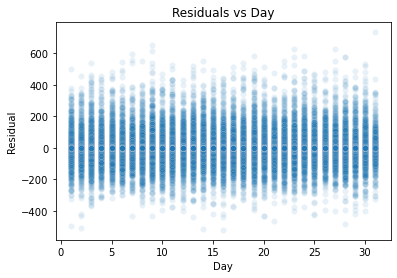

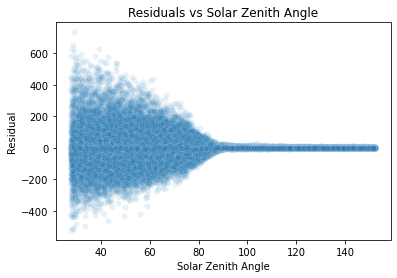

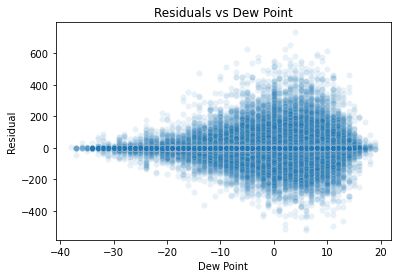

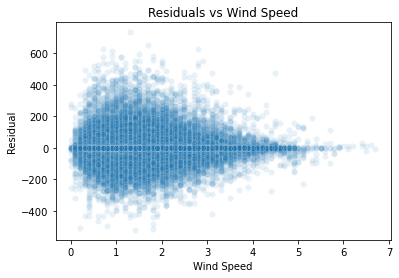

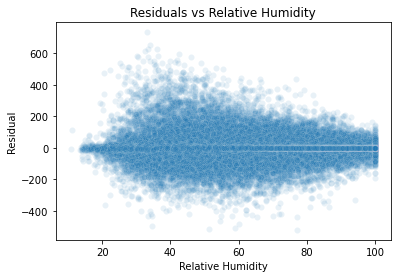

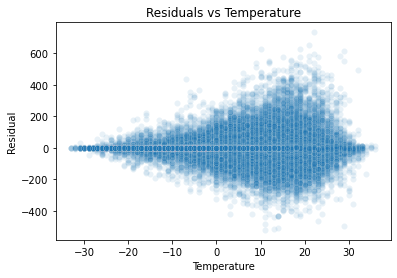

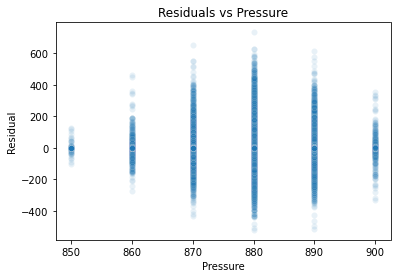

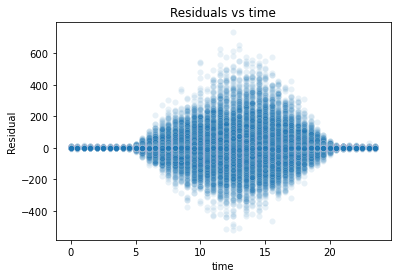

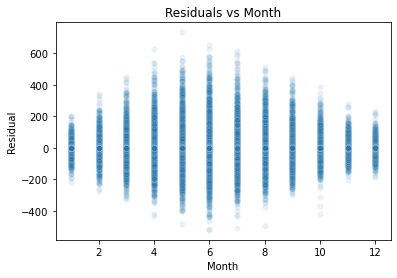

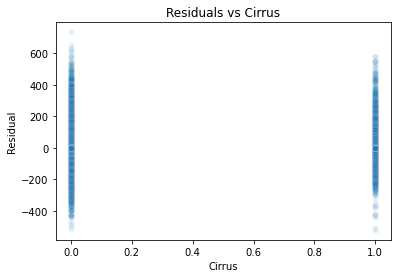

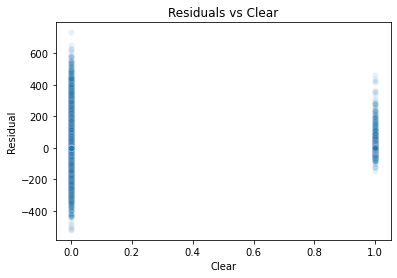

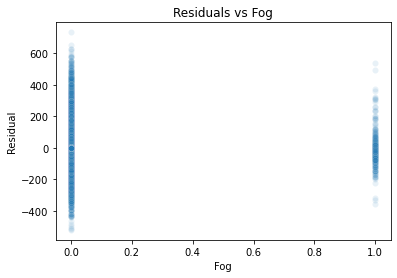

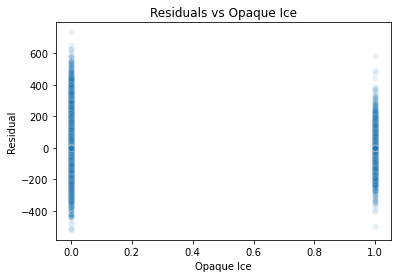

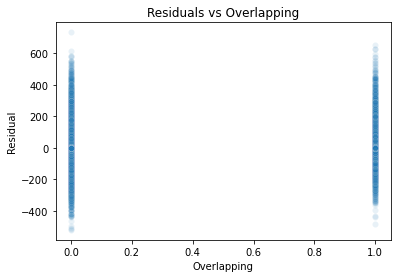

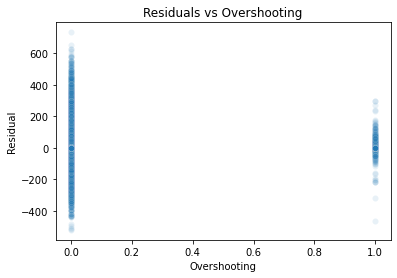

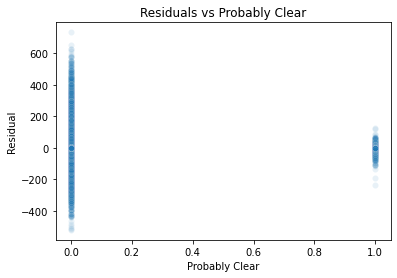

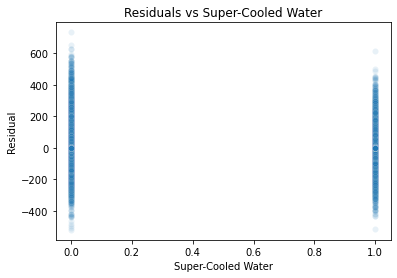

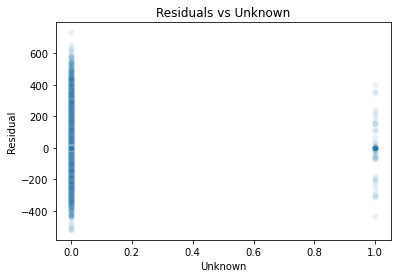

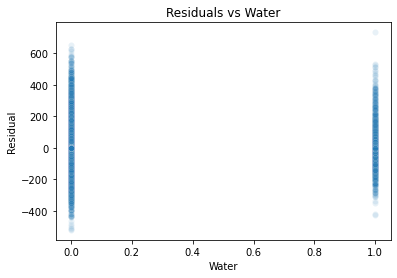

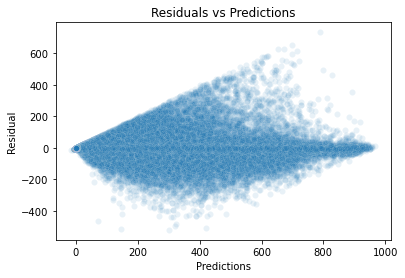

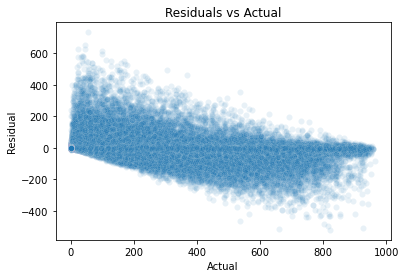

In [491]:
for col in result_xg.drop('Residual', axis=1):
    sns.scatterplot(x=col, y='Residual', data=result_xg, alpha=0.1)
    plt.title(f'Residuals vs {col}')
    plt.show()

We do observer really similar patters in the numerical data. We can put them side by side

#### 3) Model Comparison

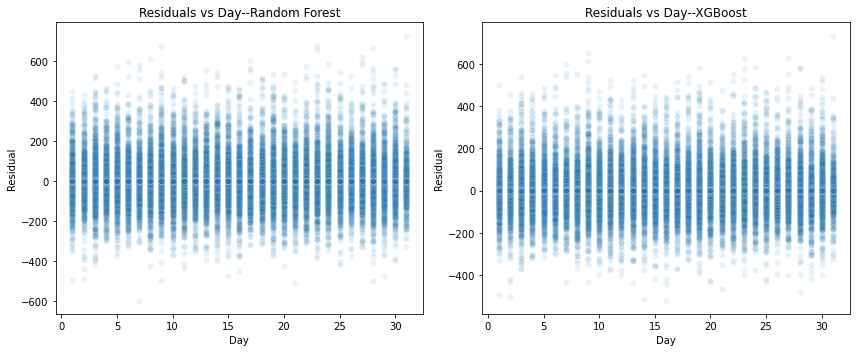

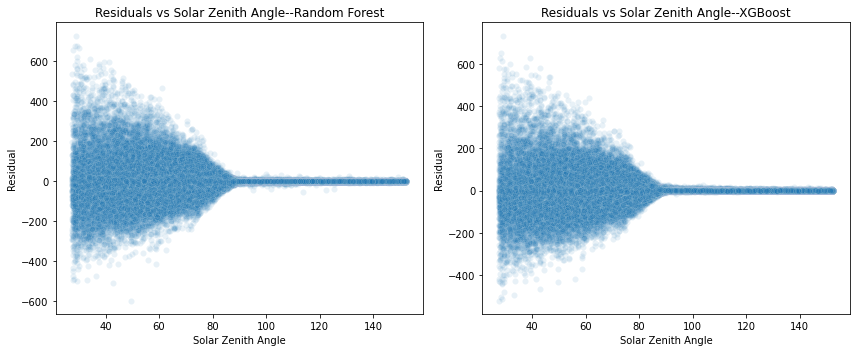

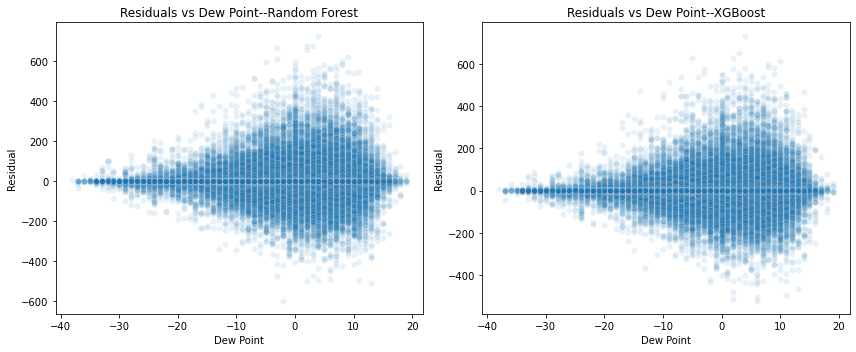

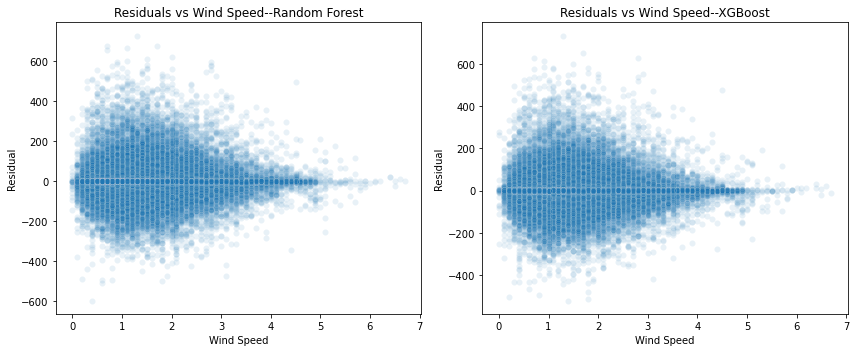

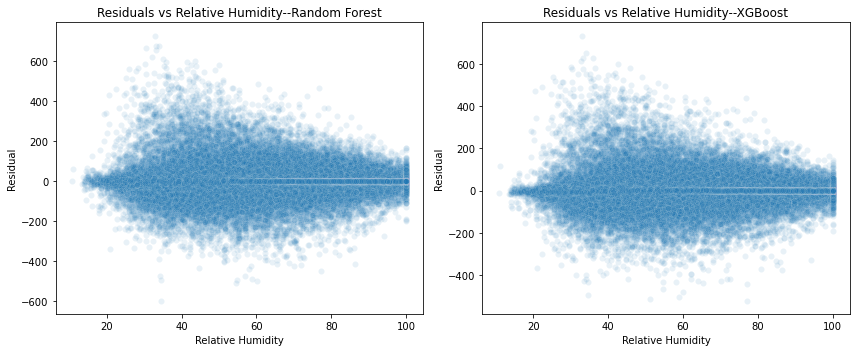

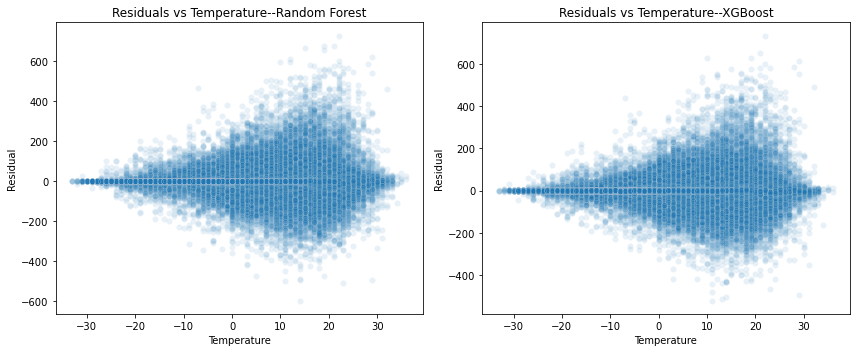

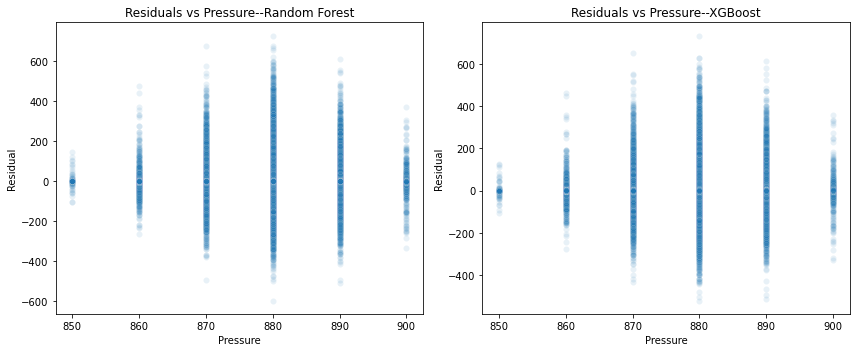

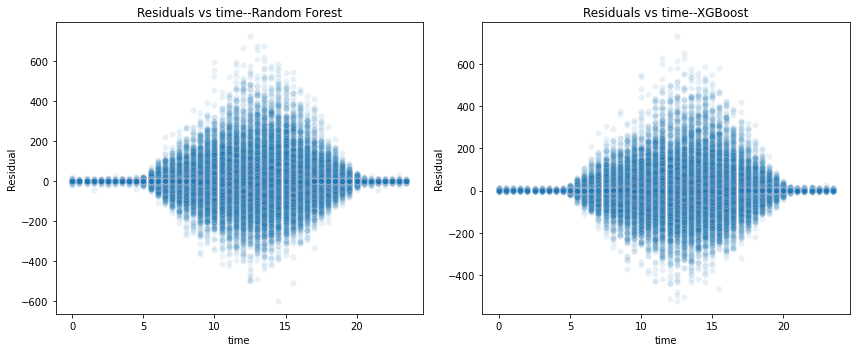

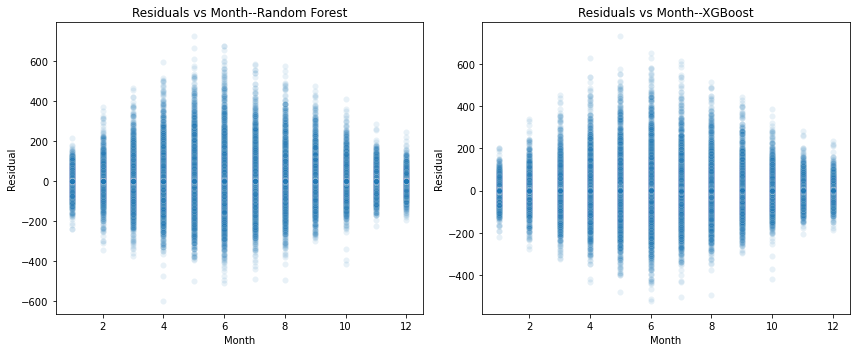

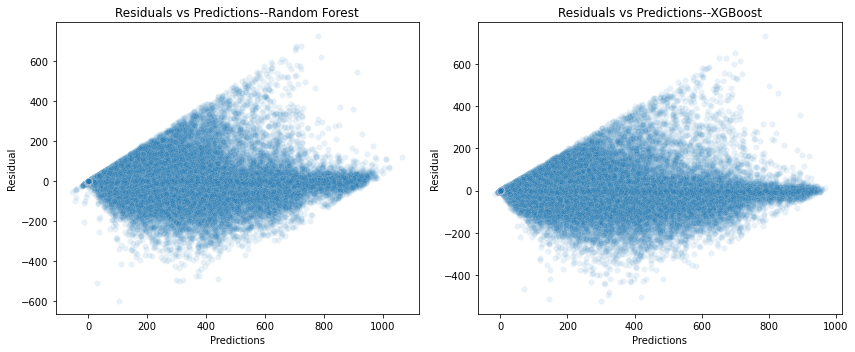

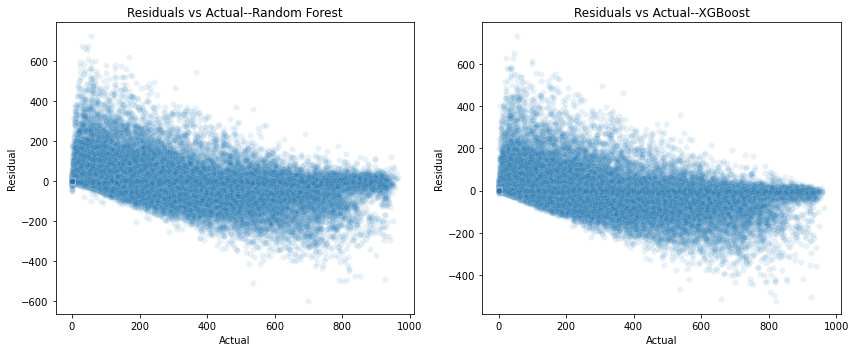

In [492]:
for col in result_rf.drop(['Residual', 'Cloud Type'], axis=1):
    plt.subplots(1, 2, figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=col, y='Residual', data=result_rf, alpha=0.1)
    plt.title(f'Residuals vs {col}--Random Forest')
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=col, y='Residual', data=result_xg, alpha=0.1)
    plt.title(f'Residuals vs {col}--XGBoost')
    plt.tight_layout()
    plt.show()
   
    
    plt.show()

They do behave extremely similarly to each other, so the XGBoost model followed the same path that it performed with certain combinations of features than others. One thing to note here, the random forest model is much more computationally expensive. The model file is large. It was my first choice to build the app but it just kept crashing the app. 

Now, it is time to sum up these 2 best models we have so far. We see that both of them how good numbers to us, with really high $R^2$ value and resealable RMSE and MAE, however, after examing the various forms of plots of the residuals, I  tend to think that the models are being 'selectively' good some combinations of features but not the others.

## Future work

As mentioned above, although the numbers looked OK with both the random forest model and XGBoost model, they both still have a lot of room to improve as the residuals are not scattered in a uniform way. We can say that the models can do a good job predicting with some combinations of features but not others. There is one feature called surface albedo that could be helpful with this situation, however, there is no easy access data I can incorporate into the app. Having some more solar radiance-related data could possibly be helpful. Some more weather data like perception could be more helpful as well. This will be the problem I am trying to solve in the future.

Neural network could be explored for modeling.

I used to a simple calculation to get solar panel output from GHI. I would like to look into this problem to get a more sophisticated way to predict solar panel output by given solar radiation. By saying that, this could be another machine learning project. 

This project can also expand horizontally by having data from multiple location in southern Alberta and Saskatchewan, as those are sunlight rich places. 

## Conclusion

In this Jupyter notebook, we tried different regression models on our dataset, we chose the best suitable model that could be implemented in our app. We suggested that the solar zenith angle has the biggest influence on solar irradiance, and we do believe there is still a lot of room for these models to improve although their numbers look good, so that we laid out the future work we would like to do on this project. 